# Shuffling Methods

test cases

In [1]:
test_inputs = ['abc', 'def', 'egh', 'ijk', 'lmn', 'opq', 'rst', 'ade', 'des', 'asd', 'a', 'sd', 'sda', 'e']
test_targets = [1, 2, 1, 1, 2, 1, 2, 3, 4, 3, 4, 4, 2, 3]

expected_output_one_class = \
(['abc','egh','ijk','def','lmn','rst','ade','asd','e','des','a','sd','opq','sda'],
 [1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1, 2])

expected_output_all_classes = \
(['opq','sda','e','sd','ijk','rst','asd','a','egh','lmn','ade','des','abc','def'],
 [1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2])

implementation

In [2]:
def build_map_classes_buffer(inputs, targets):
    '''
    Build a dictionary which has the targets as keys and all the corresponding inputs as values
    -- Params:
    @inputs: input data for the model
    @targets: desired outcome for the model given that it gets @inputs
    -- Return: dictionary
    '''
    # build a dictionary to grab pairs from
    map_classes_buffer = defaultdict(list) # stores class -> inputs pairs
    list(map(lambda x, y: map_classes_buffer[y].append(x), inputs, targets)) #without list, the writes to the map are not commited
    return map_classes_buffer

In [3]:
from collections import defaultdict
import numpy as np
from sklearn.utils import shuffle

def sort_one_class(inputs, targets, batch_size, use_shuffle=True, random_state=None):
    '''
    Splits the data (inputs and targets) into as many homogeneous batches as possible,
    i.e. that in as many cases as possible, the batches consist of one target only.
    -- Params:
    @inputs: input data for the model
    @targets: desired outcome for the model given that it gets @inputs
    @batch_size: number of samples per batch
    @use_shuffle: shuffle the data beforehand
    -- Return: one 2d list for the inputs, one 2d list for the targets
    '''
    
    assert len(inputs) == len(targets), 'Inputs and targets do not have the same size'
    
    if use_shuffle:        
        inputs, targets = shuffle(inputs, targets, random_state=random_state)
    
    input_batches = []
    target_batches = []
    inputs_buffer = [] # store inputs that don't fit into homogeneous batches anymore
    targets_buffer = []
    
    num_batches = np.ceil(len(inputs) / batch_size)
    map_classes_buffer = build_map_classes_buffer(inputs, targets)
    
    for target in map_classes_buffer.keys():
        while len(map_classes_buffer[target]) > 0:
            taken_inputs, retrieved_inputs = map_classes_buffer[target][:batch_size], map_classes_buffer[target][batch_size:]
            if len(taken_inputs) < batch_size:
                inputs_buffer.extend(taken_inputs)
                targets_buffer.extend([target for taken_input in taken_inputs])
            else:
                input_batches.extend(taken_inputs)
                target_batches.extend([target for taken_input in taken_inputs])
            map_classes_buffer[target] = retrieved_inputs
            
    # take missing values
    while len(inputs_buffer) > 0:
        taken_inputs, inputs_buffer = inputs_buffer[:batch_size], inputs_buffer[batch_size:]
        taken_targets, targets_buffer = targets_buffer[:batch_size], targets_buffer[batch_size:]
        input_batches.extend(taken_inputs)
        target_batches.extend(taken_targets)
                
    return input_batches, target_batches
 
sort_one_class(test_inputs, test_targets, batch_size=3, use_shuffle=False)
assert sort_one_class(test_inputs, test_targets, batch_size=3, use_shuffle=False) == expected_output_one_class, \
    'Actual and expected outputs differ!'

In [4]:
from copy import deepcopy
from sklearn.utils import shuffle

def sort_all_classes(inputs, targets, batch_size, use_shuffle=True, random_state=None):
    '''
    Splits the data (inputs and targets) into as many purely heterogeneous batches as possible,
    i.e. that in as many cases as possible, the batches consist of all targets.
    -- Params:
    @inputs: input data for the model
    @targets: desired outcome for the model given that it gets @inputs
    @batch_size: number of samples per batch
    @use_shuffle: shuffle the data beforehand
    -- Return: one 2d list for the inputs, one 2d list for the targets
    '''
    
    def try_pop(buffer):
        try:
            return buffer.pop()
        except:
            pass
            
    
    assert len(inputs) == len(targets), 'Inputs and targets do not have the same size'
    
    if use_shuffle:
        inputs, targets = shuffle(inputs, targets, random_state=random_state)
    
    input_batches = []
    target_batches = []
    inputs_buffer = [] # store inputs that don't fit into purely heterogeneous batches anymore
    targets_buffer = []
    
    num_batches = np.ceil(len(inputs) / batch_size)
    map_classes_buffer = build_map_classes_buffer(inputs, targets)
    
    # check if all targets in map class buffer have at least one element
    sorted_inputs = []
    sorted_targets = []
    copy_map_classes_buffer = deepcopy(map_classes_buffer)
    while any(list(map(lambda x: len(map_classes_buffer[x]) > 0, map_classes_buffer))):
        taken_targets = list(map(lambda x: x if try_pop(copy_map_classes_buffer[x]) is not None else None,\
                                 copy_map_classes_buffer)) # get one 'column'
        taken_inputs = list(map(lambda x: try_pop(map_classes_buffer[x]), map_classes_buffer)) # get one 'column'
        sorted_inputs.extend(taken_inputs)
        sorted_targets.extend(taken_targets)
        
    sorted_inputs = [val for val in sorted_inputs if val is not None] # None vals due to try_pop workaround
    sorted_targets = [val for val in sorted_targets if val is not None]
    while len(sorted_inputs) > batch_size:
        input_batches.extend(sorted_inputs[:batch_size])
        target_batches.extend(sorted_targets[:batch_size])
        sorted_inputs, sorted_targets = sorted_inputs[batch_size:], sorted_targets[batch_size:]
        
    if len(sorted_inputs) > 0: # if there are any values left
        input_batches.extend(sorted_inputs)
        target_batches.extend(sorted_targets)
                
    return input_batches, target_batches 

sort_all_classes(test_inputs, test_targets, batch_size=3, use_shuffle=False)
assert sort_all_classes(test_inputs, test_targets, batch_size=3, use_shuffle=False) == expected_output_all_classes, \
    'Actual and expected outputs differ!'

In [5]:
import numpy as np
np.random.seed(42)

def weighted_random_sampling(inputs, targets, weighted_indices, batch_size=3):
    '''
    In weighted random sampling (WRS) the items are weighted and the probability of 
    each item to be selected is determined by its relative weight.
    -- Params:
    @inputs: input data for the model
    @targets: desired outcome for the model given that it gets @inputs
    @weighted_indices: dictionary containing which index of the samples has which probability
    @batch_size: number of samples per batch
    -- Return: one batch of the inputs, one batch of the targets
    '''
    eps = 0.0000001 # small threshold to accept rounding errors when comparing float values
    
    assert len(inputs) == len(targets), 'The number of inputs to pull from must fit the number of targets'
    assert len(inputs) == len(weighted_indices), 'The number of inputs to pull from must fit the given weighted indices'
    assert type(weighted_indices) == dict, 'The weighted indices must be given as a dictionary'
    assert sum(weighted_indices.values()) < 1 + eps and sum(weighted_indices.values()) > 1 - eps, \
        'The sum of the values for the input must add up to 1.'
    
    pulled_samples = []
    pulled_targets = []
    for _ in range(batch_size):
        # calculate the weights of an element to be pulled
        # must be recalculated each round, as the values have to add up to 1
        pulled_index = np.random.choice(list(weighted_indices.keys()), p = list(weighted_indices.values()))
        weighted_indices[pulled_index] = 0
        sum_of_values = sum(weighted_indices.values())
        for index, weight in weighted_indices.items():
            weighted_indices[index] = weight / sum_of_values
        pulled_samples.append(inputs[pulled_index])
        pulled_targets.append(targets[pulled_index])
    return pulled_samples, pulled_targets
    
    
inputs = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'] # will be tensors
targets = [0, 0, 0, 1, 1, 0, 1, 1]
weighted_indices = {
    0: 0.3,
    1: 0.05,
    2: 0.2,
    3: 0.05,
    4: 0.05,
    5: 0.15,
    6: 0.05,
    7: 0.15
}

weighted_random_sampling(inputs, targets, weighted_indices, batch_size=3)

(['c', 'h', 'f'], [0, 1, 0])

In [6]:
import operator

def weighted_highest_sampling(inputs, targets, weighted_indices, batch_size=3):
    '''
    In weighted random sampling (WRS) the items are weighted and the probability of 
    each item to be selected is determined by its relative weight.
    -- Params:
    @inputs: input data for the model
    @targets: desired outcome for the model given that it gets @inputs
    @weighted_indices: dictionary containing which index of the samples has which probability
    @batch_size: number of samples per batch
    -- Return: one batch of the inputs, one batch of the targets
    '''
    
    assert len(inputs) == len(targets), 'The number of inputs to pull from must fit the number of targets'
    assert len(inputs) == len(weighted_indices), 'The number of inputs to pull from must fit the given weighted indices'
    assert type(weighted_indices) == dict, 'The weighted indices must be given as a dictionary'
      
    pulled_samples = []
    pulled_targets = []
    for _ in range(batch_size):
        pulled_index = max(weighted_indices.items(), key=operator.itemgetter(1))[0]
        weighted_indices[pulled_index] = 0
        pulled_samples.append(inputs[pulled_index])
        pulled_targets.append(targets[pulled_index])
    return pulled_samples, pulled_targets
    
    
inputs = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'] # will be tensors
targets = [0, 0, 0, 1, 1, 0, 1, 1]
weighted_indices = {
    0: 0.3,
    1: 0.05,
    2: 0.2,
    3: 0.05,
    4: 0.05,
    5: 0.15,
    6: 0.05,
    7: 0.15
}

weighted_highest_sampling(inputs, targets, weighted_indices, batch_size=3)

(['a', 'c', 'f'], [0, 0, 0])

--- 

### Runtime analysis

In [7]:
import timeit
import numpy as np
import copy
import matplotlib.pyplot as plt

In [8]:
num_samples = 10000
batch_size = 64
# prepare test data
X = np.random.rand(num_samples, 32, 32)
Y = np.random.randint(10, size=num_samples)
weighted_indices = {index: abs(np.random.normal(loc=0, scale=1)) for index in range(len(X))}
sum_indices = sum(weighted_indices.values())
for key, value in weighted_indices.items():
    weighted_indices[key] /= sum_indices

In [9]:
times = {}

In [10]:
from sklearn.utils import shuffle

In [11]:
X_copy, Y_copy, wi_copy = X.copy(), Y.copy(), weighted_indices.copy()
start = timeit.default_timer()
_ = shuffle(X_copy, Y_copy)
stop = timeit.default_timer()
times['shuffle'] = stop - start

In [12]:
X_copy, Y_copy, wi_copy = X.copy(), Y.copy(), weighted_indices.copy()
start = timeit.default_timer()
_ = weighted_highest_sampling(X_copy, Y_copy, wi_copy,  batch_size=batch_size)
stop = timeit.default_timer()
times['whs'] = stop - start

In [13]:
X_copy, Y_copy, wi_copy = X.copy(), Y.copy(), weighted_indices.copy()
start = timeit.default_timer()
_ = weighted_random_sampling(X_copy, Y_copy, wi_copy,  batch_size=batch_size)
stop = timeit.default_timer()
times['wrs'] = stop - start

In [14]:
X_copy, Y_copy, wi_copy = X.copy(), Y.copy(), weighted_indices.copy()
start = timeit.default_timer()
_ = sort_one_class(X_copy, Y_copy, batch_size)
stop = timeit.default_timer()
times['homogeneous'] = stop - start

In [15]:
X_copy, Y_copy, wi_copy = X.copy(), Y.copy(), weighted_indices.copy()
start = timeit.default_timer()
_ = sort_all_classes(X_copy, Y_copy, batch_size)
stop = timeit.default_timer()
times['heterogeneous'] = stop - start

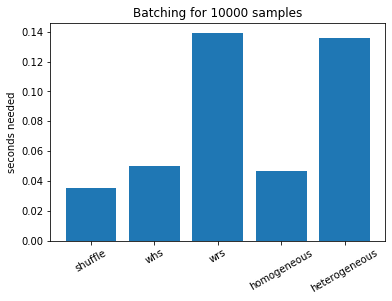

In [16]:
plt.bar(times.keys(), times.values())
plt.xticks(rotation=30)
plt.ylabel('seconds needed')
plt.title('Batching for {} samples'.format(num_samples))
plt.show()